# Cognition and Computation Project

## Import Libraries

In [1]:
import math

from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import scipy
import pandas as pd
import numpy as np

## Restricted Boltzmann Machine

In [2]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, k=1):
        super(RBM, self).__init__()

        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.k = k

    @torch.no_grad()
    def sample_h(self, v):
        prob_h = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return prob_h, torch.bernoulli(prob_h)

    @torch.no_grad()
    def sample_v(self, h):
        prob_v = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return prob_v, torch.bernoulli(prob_v)

    @torch.no_grad()
    def reconstruct(self, v, return_sample=False):
        prob_h, h = self.sample_h(v)
        prob_v_rec, v_rec = self.sample_v(h if return_sample else prob_h)
        return prob_v_rec, v_rec

    def free_energy(self, v):
        vbias_term = v @ self.v_bias
        hidden_term = torch.sum(
            F.softplus(v @ self.W.t() + self.h_bias),
            dim=1
        )
        return -vbias_term - hidden_term

    @torch.no_grad()
    def gibbs_k(self, v):
        prob_h, h = self.sample_h(v)
        prob_v = None
        for _ in range(self.k):
            prob_v, v = self.sample_v(h)
            prob_h, h = self.sample_h(v)
        return prob_v, v

    def fit(self, dataloader, learning_rate=0.001, epochs=5, device=None):
        self.to(device)

        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        recon_loss_history = []
        for epoch in range(epochs):
            epoch_recon_loss_history = []

            for batch in dataloader:
                v0, label = batch[0], batch[1]

                v0 = v0.flatten(1)
                v0 = v0.to(device)

                prob_v, v = self.gibbs_k(v0)

                loss = (self.free_energy(v0) - self.free_energy(v)).mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                recon_loss = F.mse_loss(v0, prob_v).item()
                epoch_recon_loss_history.append(recon_loss)

            epoch_recon_loss = float(np.mean(epoch_recon_loss_history))
            recon_loss_history.append(epoch_recon_loss)

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f'Epoch {epoch+1}/{epochs}, MSE: {epoch_recon_loss:.6f}')

        return recon_loss_history

## Deep Belief Network

In [5]:
class DBN(nn.Module):
    def __init__(self, n_visible, n_hidden=[], k=1):
        super(DBN, self).__init__()

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.k = k

        sizes = [n_visible] + self.n_hidden
        self.rbms = nn.ModuleList([
            RBM(n_visible=sizes[i], n_hidden=sizes[i + 1], k=k)
            for i in range(len(sizes) - 1)
        ])

    @torch.no_grad()
    def encode(self, v, return_samples=False):
        """Forward pass"""
        x = v
        for rbm in self.rbms:
            prob_h, h = rbm.sample_h(x)
            x = h if return_samples else prob_h
        return prob_h, h

    @torch.no_grad()
    def decode(self, h, return_samples=False):
        """Backward (generative) pass"""
        x = h
        for rbm in reversed(self.rbms):
            prob_v, v = rbm.sample_v(x)
            x = v if return_samples else prob_v
        return prob_v, v

    @torch.no_grad()
    def reconstruct(self, v, return_samples=False):
        prob_h, h = self.encode(v, return_samples=return_samples)
        prob_v_rec, v_rec = self.decode(
            h if return_samples else prob_h, return_samples=return_samples
        )
        return prob_v_rec, v_rec

    def fit(self, dataloader, learning_rate=0.001, epochs=5, device=None, sample_mode=False):
        histories = []
        for layer_idx, rbm in enumerate(self.rbms):
            print(
                f"Pretraining layer {layer_idx+1}/{len(self.rbms)}: ({rbm.W.shape[1]} -> {rbm.W.shape[0]})"
            )

            hist = rbm.fit(
                dataloader=dataloader,
                learning_rate=learning_rate,
                epochs=epochs,
                device=device
            )
            histories.append(hist)

            with torch.no_grad():
                transformed_batches = []
                for batch in dataloader:
                    v0, label = batch[0], batch[1]

                    v0 = v0.flatten(1)
                    v0 = v0.to(device)

                    prob_h, h = rbm.sample_h(v0)
                    transformed_batches.append(h if sample_mode else prob_h)

                # New dataloader for next layer
                dataset = torch.cat(transformed_batches, dim=0)
                dummy_labels = torch.zeros(
                    dataset.size(0), dtype=torch.long, device=dataset.device
                )
                dataloader = torch.utils.data.DataLoader(
                    TensorDataset(dataset, dummy_labels),
                    batch_size=dataloader.batch_size,
                    shuffle=True
                )

        return histories

## Utils functions

In [4]:
def show_img(img, digit=None):
    if digit is not None:
        print(f'The image shows the digit: {digit}')
    img = img.cpu()
    plt.imshow(img, cmap='gray')
    plt.show()


def compare_imgs(imgs, digit):
    print(f'The images show the digit: {digit}')
    n_imgs = len(imgs)
    for i, img in enumerate(imgs):
        img = img.cpu()
        plt.subplot(1, n_imgs, i+1)
        plt.imshow(img, cmap='gray')
    plt.show()

## Training on MNIST

In [6]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f'Using device: {device_name}')

Using device: cpu


In [7]:
mnist_train_ds = torchvision.datasets.MNIST(
    root='mnist', train=True, download=True, transform=torchvision.transforms.ToTensor()
)
mnist_test_ds = torchvision.datasets.MNIST(
    root='mnist', train=False, download=True, transform=torchvision.transforms.ToTensor()
)

mnist_train_ds.data = mnist_train_ds.data / 255
mnist_test_ds.data = mnist_test_ds.data / 255

mnist_train_ds.data = mnist_train_ds.data.to(device)
mnist_test_ds.data = mnist_test_ds.data.to(device)
mnist_train_ds.targets = mnist_train_ds.targets.to(device)
mnist_test_ds.targets = mnist_test_ds.targets.to(device)

mnist_img_shape = (28, 28)
batch_size = 32

mnist_train_loader = DataLoader(
    mnist_train_ds, batch_size=batch_size, shuffle=True
)
mnist_test_loader = DataLoader(
    mnist_test_ds, batch_size=batch_size, shuffle=False
)

The image shows the digit: 5


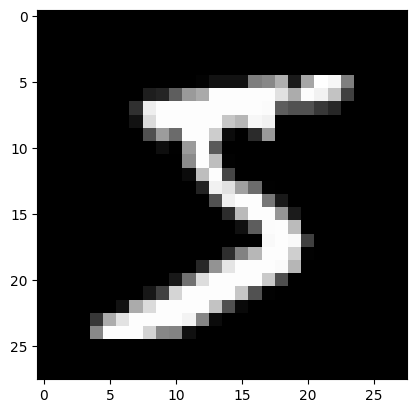

In [8]:
idx = 0
img = mnist_train_ds.data[idx]
digit = mnist_train_ds.targets[idx]

show_img(img, digit)

In [9]:
print(f'Training dataset shape: {mnist_train_ds.data.shape}')
print(f'Test dataset shape: {mnist_test_ds.data.shape}')

Training dataset shape: torch.Size([60000, 28, 28])
Test dataset shape: torch.Size([10000, 28, 28])


In [10]:
# Initialize RBM
n_visible = mnist_img_shape[0] * mnist_img_shape[1]
n_hidden = 128

rbm = RBM(
    n_visible=n_visible,
    n_hidden=n_hidden,
    k=1
)

rbm_weights_file_name = 'rbm_1.pth'

In [11]:
# RBM training
loss_history = rbm.fit(
    dataloader=mnist_train_loader,
    learning_rate=0.001,
    epochs=50,
    device=device
)

Epoch 1/1, MSE: 0.014996


In [ ]:
# Saving RBM weights to file
torch.save(rbm.state_dict(), rbm_weights_file_name)
print(f'RBM model weights saved to "{rbm_weights_file_name}"')

RBM model weights saved to "rbm_weights.pth"


In [11]:
# Downloading weights
%%capture
!wget -O {rbm_weights_file_name} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{rbm_weights_file_name}"

In [12]:
# Loading weights from file
rbm.load_state_dict(torch.load(rbm_weights_file_name, map_location=device))
rbm.to(device)
print(f'RBM model weights loaded from "{rbm_weights_file_name}"')

RBM model weights loaded from "rbm_1.pth"


The images show the digit: 0


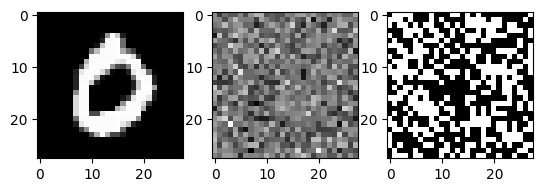

In [98]:
test_idx = 3
test_img = mnist_test_ds.data[test_idx]
test_digit = mnist_test_ds.targets[test_idx]

_prob_v, _v = rbm.reconstruct(test_img.reshape(1, n_visible), return_sample=False)
reconstruct_prob_img = _prob_v.reshape(mnist_img_shape).detach()
reconstruct_img = _v.reshape(mnist_img_shape).detach()

compare_imgs([test_img, reconstruct_prob_img, reconstruct_img], test_digit)

In [12]:
# Initialize DBN
dbn = DBN(
    n_visible=n_visible,
    n_hidden=[400, 500, 800],
    k=1
)

dbn_weights_file_name = 'dbn_1.pth'

In [13]:
# DBN training
dbn_loss_histories = dbn.fit(
    dataloader=mnist_train_loader,
    learning_rate=0.001,
    epochs=1,
    device=device,
    sample_mode=False,
)

Pretraining layer 1/3: (784 -> 400)
Epoch 1/1, MSE: 0.009609
Pretraining layer 2/3: (400 -> 500)
Epoch 1/1, MSE: 0.009302
Pretraining layer 3/3: (500 -> 800)
Epoch 1/1, MSE: 0.005907


In [ ]:
# Saving DBN weights to file
torch.save(dbn.state_dict(), dbn_weights_file_name)
print(f'DBN model weights saved to "{dbn_weights_file_name}"')

DBN model weights saved to "dbn_weights.pth"


In [17]:
# Downloading weights
%%capture
!wget -O {dbn_weights_file_name} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{dbn_weights_file_name}"

In [18]:
# Loading weights from file
dbn.load_state_dict(torch.load(dbn_weights_file_name, map_location=device))
dbn.to(device)
print(f'DBN model weights loaded from "{dbn_weights_file_name}"')

DBN model weights loaded from "dbn_1.pth"


The images show the digit: 1


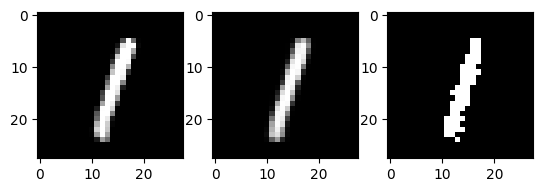

In [19]:
test_idx = 5
test_img = mnist_test_ds.data[test_idx]
test_digit = mnist_test_ds.targets[test_idx]

_prob_v, _v = dbn.reconstruct(test_img.reshape(1, n_visible))
reconstruct_prob_img = _prob_v.reshape(mnist_img_shape).detach()
reconstruct_img = _v.reshape(mnist_img_shape).detach()

compare_imgs([test_img, reconstruct_prob_img, reconstruct_img], test_digit)

## Visualizing receptive fields

In [14]:
def get_rbm_weights(rbm):
    return rbm.W.detach().cpu().numpy()


def apply_threshold(weights, threshold):
    return weights * (np.abs(weights) > threshold)


def apply_min_max_scaler(weights):
    shape = weights.shape
    scaler = MinMaxScaler()
    weights = scaler.fit_transform(weights.ravel().reshape(-1, 1))
    weights = weights.reshape(shape)
    return weights


def plot_layer_receptive_fields(weights):
    n_filters = 100
    n_cols = n_rows = int(math.sqrt(n_filters))
    fig, axs = plt.subplots(
        n_rows, n_cols,
        sharex=True, sharey=True, figsize=(15, 15)
    )

    for i in range(n_filters):
        row = i // n_cols
        col = i % n_cols
        axs[row, col].imshow(
            weights[:, i].reshape(mnist_img_shape),
            cmap="gray"
        )
        axs[row, col].axis("off")

    plt.tight_layout()
    display(fig)
    plt.close(fig)

======= Layer 1 =======


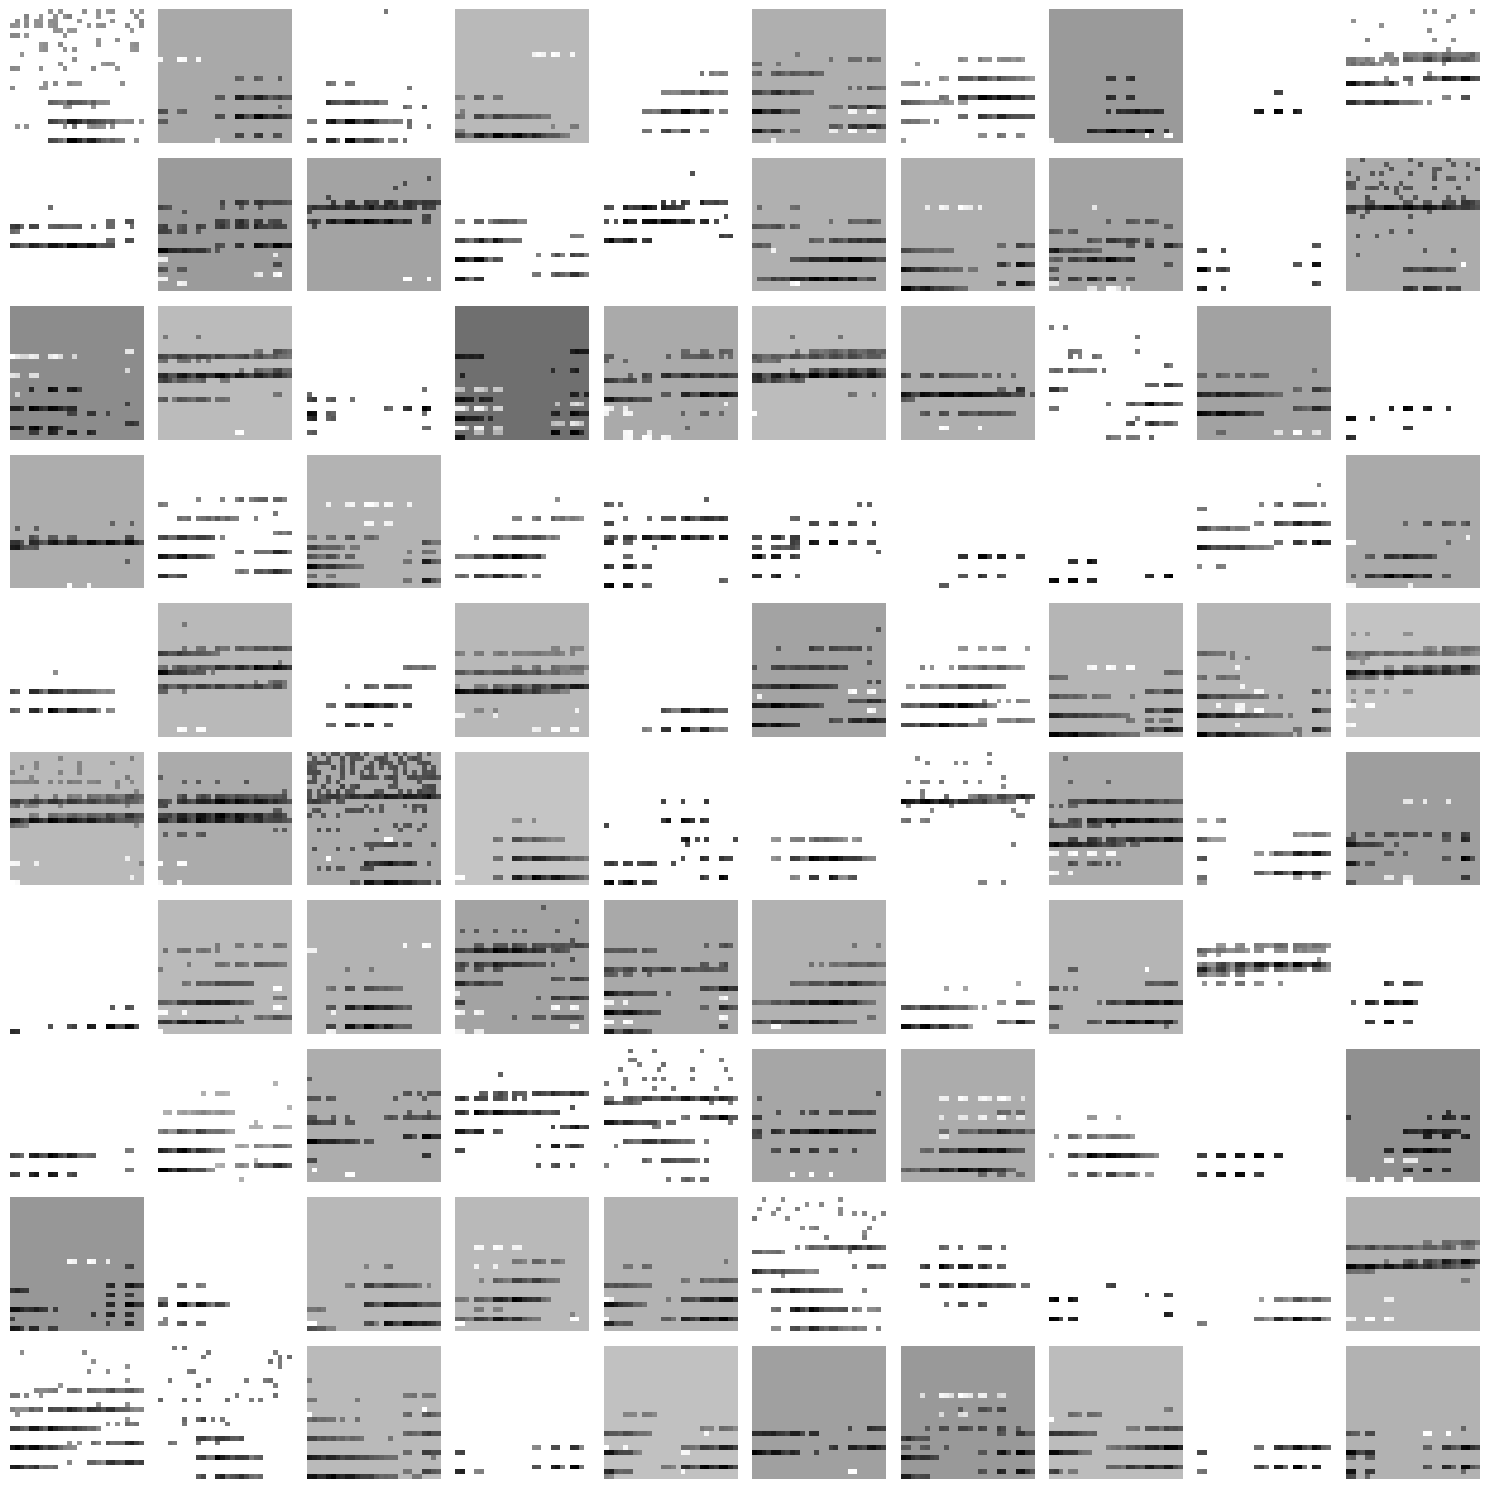


======= Layer 2 =======


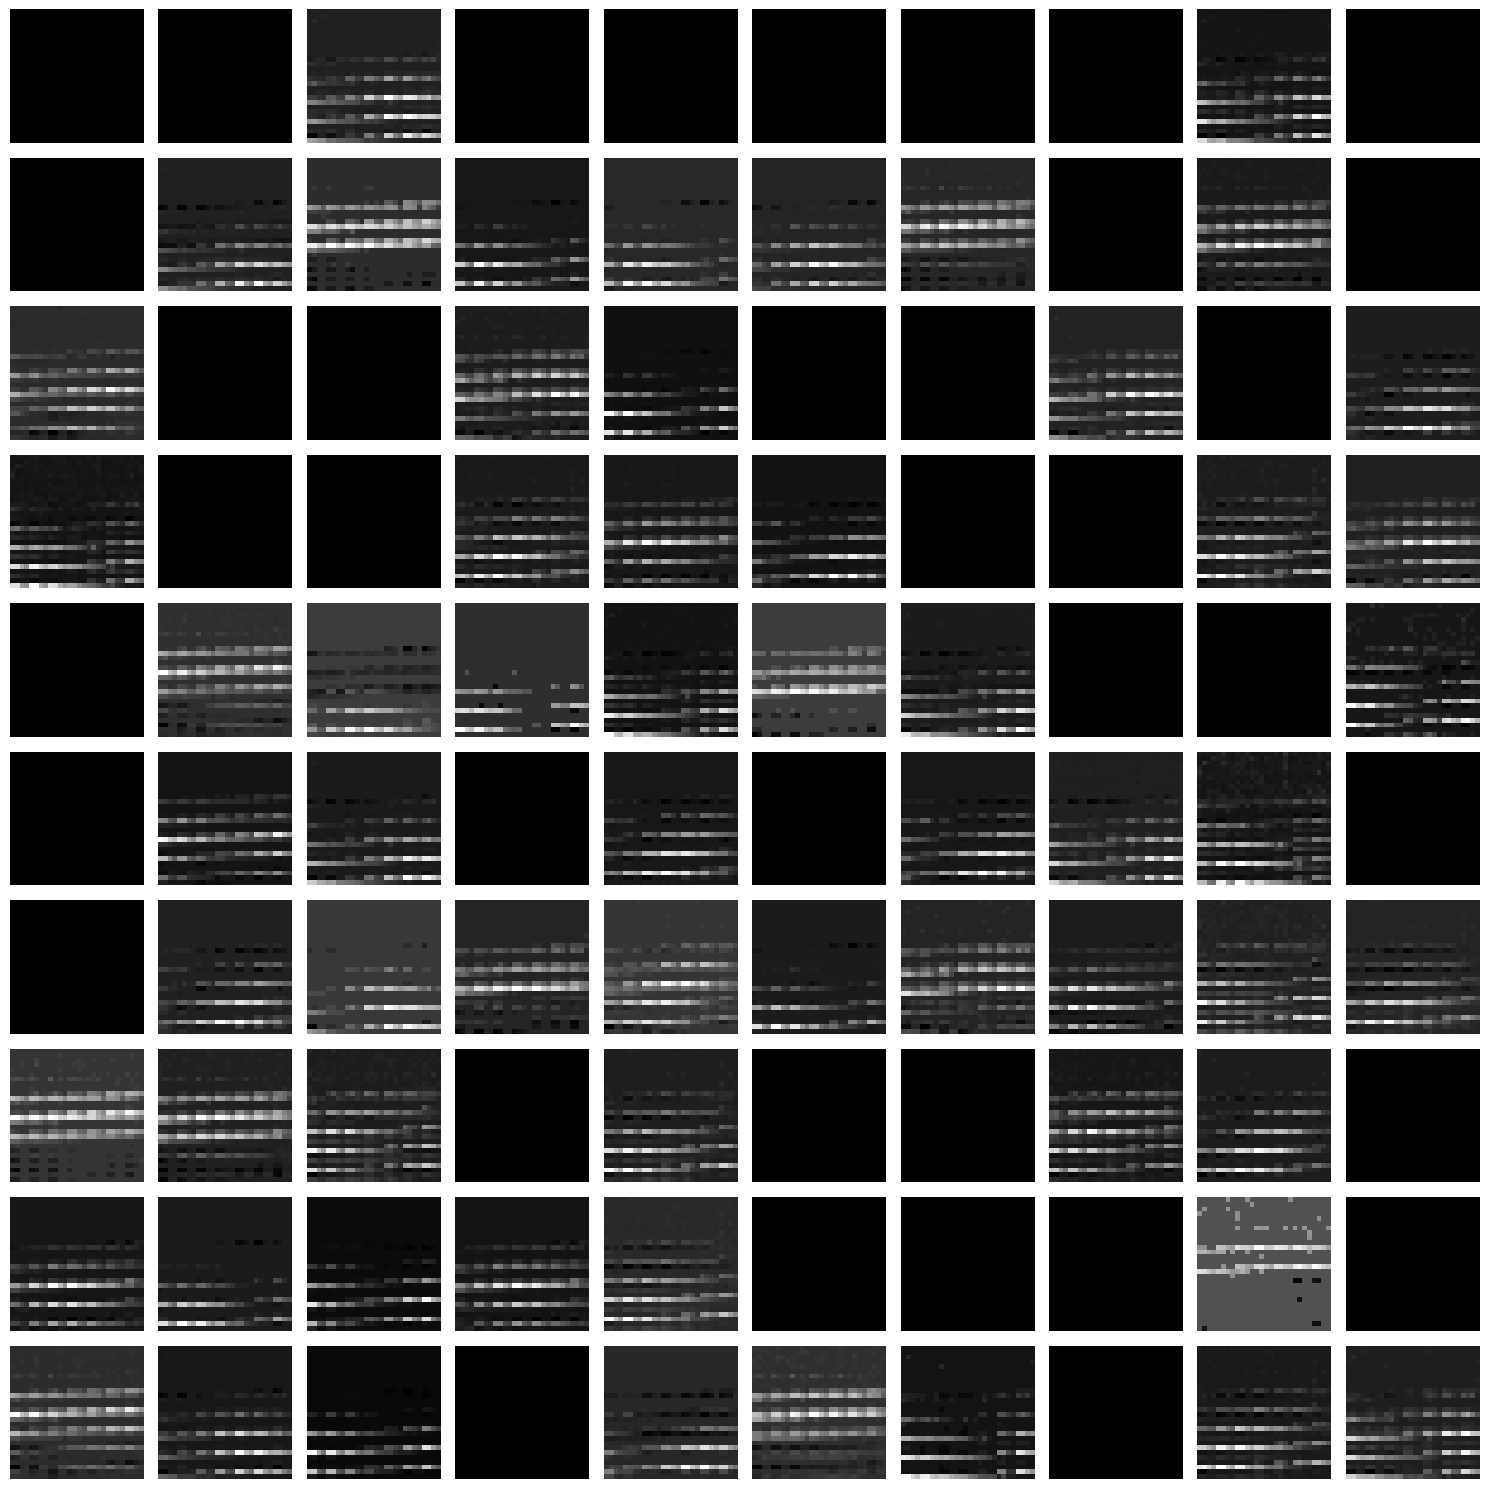


======= Layer 3 =======


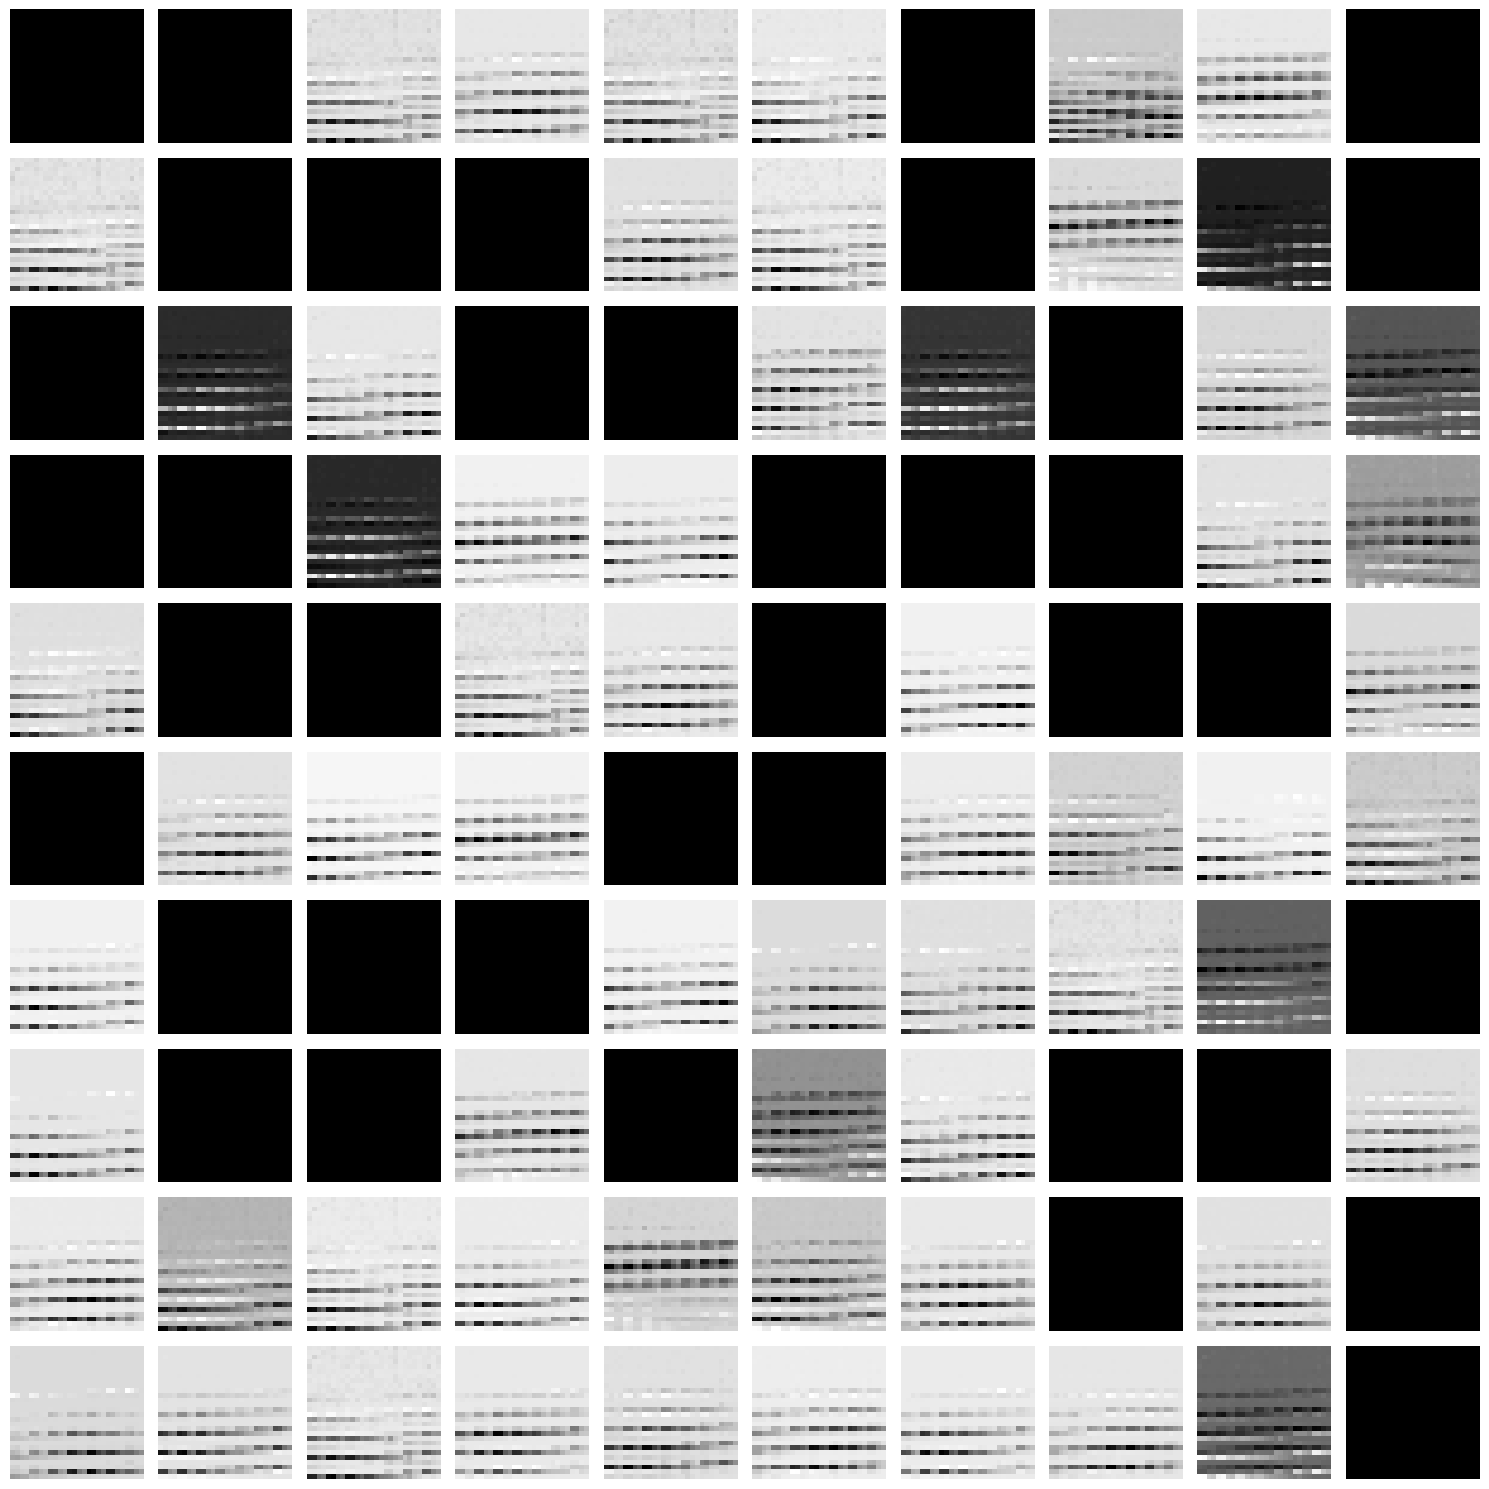

In [15]:
weights_prod = None
for layer_idx, rbm in enumerate(dbn.rbms):
    layer_weights = get_rbm_weights(rbm)
    layer_weights = apply_threshold(layer_weights, 0.1)

    # Linear projection
    weights_prod = (
        weights_prod @ layer_weights.T
    ) if weights_prod is not None else layer_weights.T

    layer_weights = apply_min_max_scaler(weights_prod)

    print(f'======= Layer {layer_idx + 1} =======')
    plot_layer_receptive_fields(layer_weights)
    print()

## Clustering internal representations

In [16]:
def get_label_mask(labels, label):
    return labels == label


def get_mean_representations(representations, labels):
    return {
        label: np.mean(representations[get_label_mask(labels, label)], axis=0)
        for label in np.unique(labels)
    }


def show_dendrogram(representations, labels):
    mean_representations = get_mean_representations(representations, labels)
    representations_matrix = np.concatenate([
        np.expand_dims(mean_representations[label], axis=0)
        for label in np.unique(labels)
    ])

    fig, ax = plt.subplots()
    linkage = scipy.cluster.hierarchy.linkage(
        representations_matrix, method='complete'
    )
    dendrogram = scipy.cluster.hierarchy.dendrogram(linkage)

    plt.tight_layout()
    display(fig)
    plt.close(fig)


def show_clusters(representations, labels):
    mean_representations = get_mean_representations(representations, labels)
    unique_labels = sorted(mean_representations.keys())
    representations_matrix = np.concatenate([
        np.expand_dims(mean_representations[label], axis=0)
        for label in unique_labels
    ])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(representations_matrix)

    fig, ax = plt.subplots()
    plt.scatter(pca_result[:, 0], pca_result[:, 1])

    for i, label in enumerate(unique_labels):
        plt.annotate(str(label), (pca_result[i, 0], pca_result[i, 1]))

    plt.tight_layout()
    display(fig)
    plt.close(fig)

======= Layer 1 =======


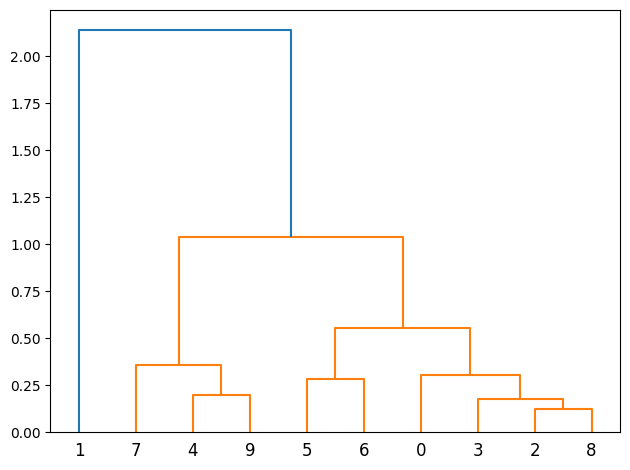

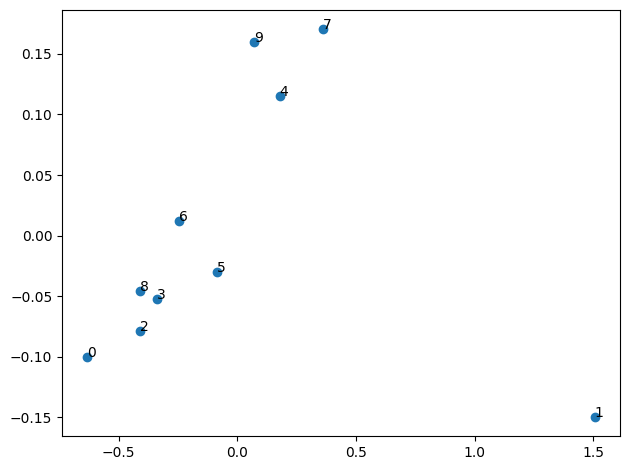


======= Layer 2 =======


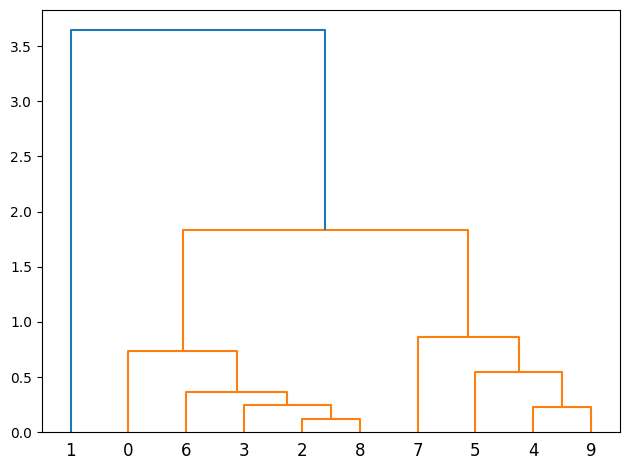

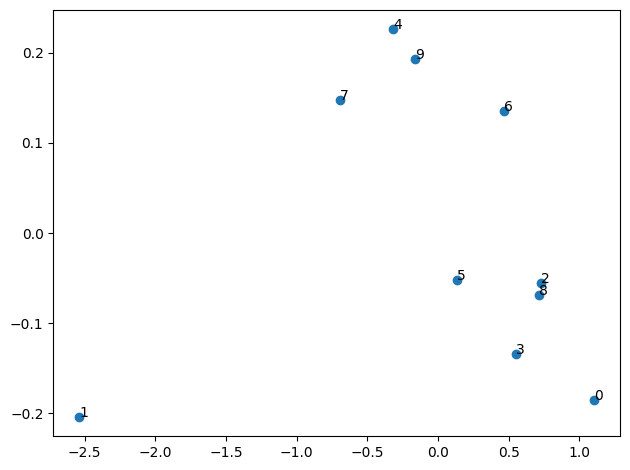


======= Layer 3 =======


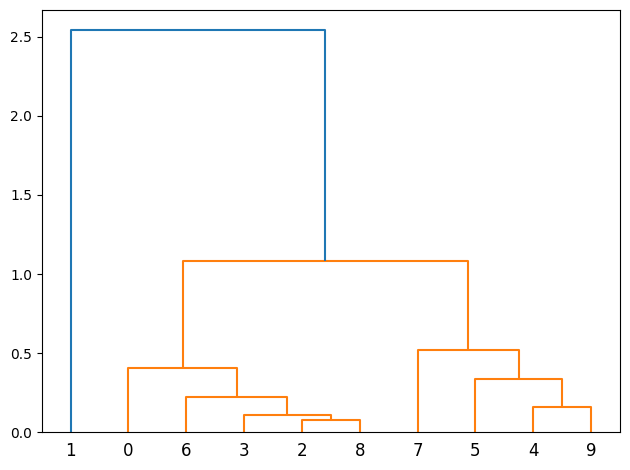

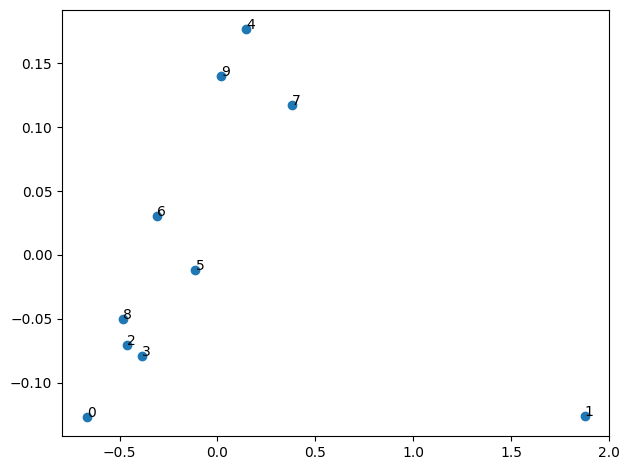

In [17]:
n = len(mnist_test_loader.dataset)
labels = mnist_test_loader.dataset.targets.cpu().numpy()

prob_h = mnist_test_loader.dataset.data.reshape(n, n_visible)
for layer_idx, rbm in enumerate(dbn.rbms):
    prob_h, h = rbm.sample_h(prob_h)

    print(f'======= Layer {layer_idx + 1} =======')
    show_dendrogram(prob_h.numpy(), labels)
    show_clusters(prob_h.numpy(), labels)
    print()

## Linear read-out layer

In [18]:
class LinearReadOutLayer(nn.Module):
  def __init__(self, n_input, n_output=10) -> None:
      super(LinearReadOutLayer, self).__init__()

      self.linear = nn.Linear(n_input, n_output)

  def forward(self, x):
    return self.linear(x)

In [19]:
linear_layers = []

for layer_idx, rbm in enumerate(dbn.rbms):
    n_input = rbm.W.shape[0]
    linear_layer = LinearReadOutLayer(n_input)
    linear_layer.to(device)

    linear_layers.append({
        'rbm': rbm,
        'linear_layer': linear_layer,
        'filename': f'linear_layer_{layer_idx+1}.pth'
    })

In [20]:
epochs = 1000

n = len(mnist_train_loader.dataset)
labels = mnist_train_loader.dataset.targets

prob_h = mnist_train_loader.dataset.data.reshape(n, n_visible)
for layer_idx, linear_layer_dict in enumerate(linear_layers):

    print(f'======= Layer {layer_idx + 1} =======')

    linear_layer = linear_layer_dict['linear_layer']
    rbm = linear_layer_dict['rbm']
    filename = linear_layer_dict['filename']

    prob_h, h = rbm.sample_h(prob_h)

    optimizer = torch.optim.Adam(linear_layer.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = linear_layer(prob_h)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    torch.save(linear_layer.state_dict(), filename)

======= Layer 1 =======
Epoch 1/1000, Loss: 2.2956
Epoch 101/1000, Loss: 2.0664
Epoch 201/1000, Loss: 1.9460
Epoch 301/1000, Loss: 1.8532
Epoch 401/1000, Loss: 1.7785
Epoch 501/1000, Loss: 1.7165
Epoch 601/1000, Loss: 1.6635
Epoch 701/1000, Loss: 1.6175
Epoch 801/1000, Loss: 1.5767
Epoch 901/1000, Loss: 1.5402
Epoch 1000/1000, Loss: 1.5074
======= Layer 2 =======
Epoch 1/1000, Loss: 2.3300
Epoch 101/1000, Loss: 2.0009
Epoch 201/1000, Loss: 1.9018
Epoch 301/1000, Loss: 1.8352
Epoch 401/1000, Loss: 1.7846
Epoch 501/1000, Loss: 1.7448
Epoch 601/1000, Loss: 1.7127
Epoch 701/1000, Loss: 1.6860
Epoch 801/1000, Loss: 1.6634
Epoch 901/1000, Loss: 1.6437
Epoch 1000/1000, Loss: 1.6265
======= Layer 3 =======
Epoch 1/1000, Loss: 2.2981
Epoch 101/1000, Loss: 2.0316
Epoch 201/1000, Loss: 1.9576
Epoch 301/1000, Loss: 1.9106
Epoch 401/1000, Loss: 1.8756
Epoch 501/1000, Loss: 1.8472
Epoch 601/1000, Loss: 1.8229
Epoch 701/1000, Loss: 1.8017
Epoch 801/1000, Loss: 1.7828
Epoch 901/1000, Loss: 1.7658
Epoc

In [31]:
# Downloading and loading weights from file
%%capture
_loaded_linear_layers = []
for linear_layer_dict in linear_layers:
    linear_layer = linear_layer_dict['linear_layer']
    filename = linear_layer_dict['filename']

    !wget -O {dbn_weights_file_name} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{filename}"

    linear_layer.load_state_dict(torch.load(filename, map_location=device))
    linear_layer.to(device)

    linear_layer_dict['linear_layer'] = linear_layer
    _loaded_linear_layers.append(linear_layer_dict)

linear_layers = _loaded_linear_layers

In [ ]:
n = len(mnist_test_loader.dataset)
labels = mnist_test_loader.dataset.targets.cpu().numpy()

prob_h = mnist_test_loader.dataset.data.reshape(n, n_visible)
for layer_idx, linear_layer_dict in enumerate(linear_layers):
    linear_layer = linear_layer_dict['linear_layer']
    rbm = linear_layer_dict['rbm']

    prob_h, h = rbm.sample_h(prob_h)

    outputs = linear_layer(prob_h)
    predictions = torch.argmax(outputs, dim=1)

    accuracy = (predictions == labels).sum().item() / len(labels)

    print(f'Layer {layer_idx + 1}: accuracy = {accuracy}')

Layer 1: accuracy = 0.9543
Layer 2: accuracy = 0.9652
Layer 3: accuracy = 0.9639


## Feed-Forward Network / Convolutional Neural Network

In [57]:
class FFN(nn.Module):
    def __init__(self, img_shape=mnist_img_shape, n_classes=10) -> None:
        super(FFN, self).__init__()

        n_input = img_shape[0] * img_shape[1]
        self.fc1 = nn.Linear(n_input, 400)
        self.fc2 = nn.Linear(400, 500)
        self.fc3 = nn.Linear(500, 800)
        self.fc4 = nn.Linear(800, n_classes)

    def forward(self, x):
        x = x.flatten(1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = self.fc4(x)

        return output

In [60]:
class CNN(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()

        self.conv_1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same')
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(3136, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.max_pool_1(x)

        x = self.conv_2(x)
        x = F.relu(x)
        x = self.max_pool_2(x)

        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        output = self.fc2(x)

        return output

In [77]:
ffn_model = FFN()

ffn_model.to(device)

test_idx = 5
test_batch = next(iter(mnist_test_loader))
test_img, test_digit = test_batch[0][test_idx], test_batch[1][test_idx]

# Creating batch
test_img = test_img.unsqueeze(0)

ffn_model(test_img)
ffn_model(test_batch[0])

summary(ffn_model, mnist_img_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
            Linear-2                  [-1, 500]         200,500
            Linear-3                  [-1, 800]         400,800
            Linear-4                   [-1, 10]           8,010
Total params: 923,310
Trainable params: 923,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.52
Estimated Total Size (MB): 3.54
----------------------------------------------------------------


In [78]:
cnn_model = CNN()

cnn_model.to(device)

test_idx = 5
test_batch = next(iter(mnist_test_loader))
test_img, test_digit = test_batch[0][test_idx], test_batch[1][test_idx]

# Creating batch
test_img = test_img.unsqueeze(0)

cnn_model(test_img)
cnn_model(test_batch[0])

summary(cnn_model, (1, mnist_img_shape[0], mnist_img_shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 256]         803,072
            Linear-6                   [-1, 10]           2,570
Total params: 824,458
Trainable params: 824,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 3.15
Estimated Total Size (MB): 3.51
----------------------------------------------------------------


## Robustness to noise

## Adversarial attacks